# Inverted Pendulum

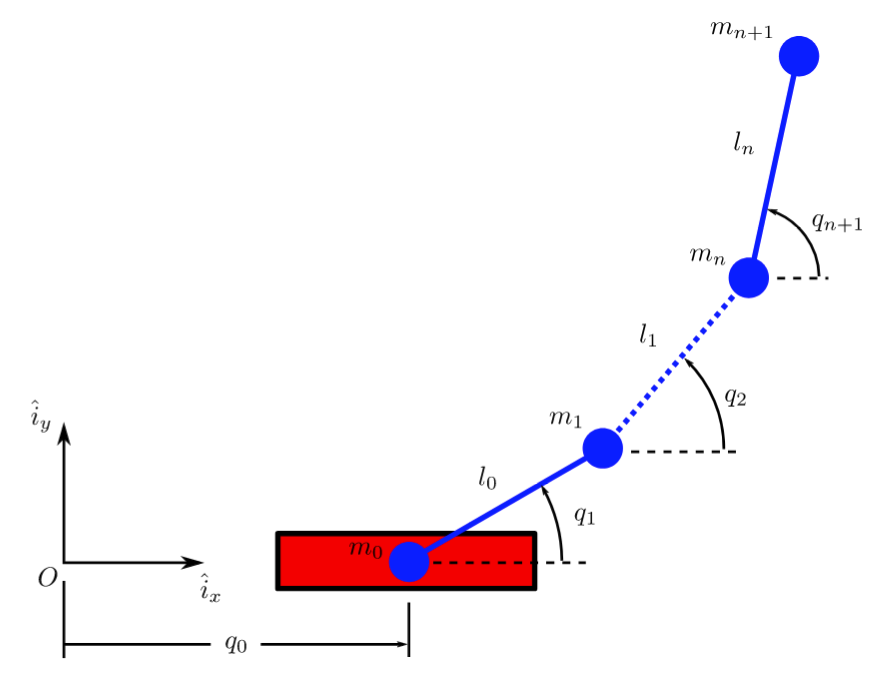

In [1]:
import sympy 
from sympy import symbols 
from sympy.physics.mechanics import *

In [2]:
#Anzahl der Pendelglieder (Verbindungspunkte)
n = 1

In [3]:
#Generelle Koordinaten
q = dynamicsymbols('q:' + str(n+1))

#Geschwindigkeiten
v = dynamicsymbols('v:' + str(n+1))

#Kraft auf Wagen
f = dynamicsymbols('f')

In [4]:
#Masse von Pendelglieder
m = symbols('m:' + str(n+1))

#Pendellänge des jeweiligen Glieds
l = symbols('l:' + str(n))

#Erdbeschleunigung und Zeit
g, t = symbols('g t')

In [5]:
#Frames
#Inertial reference
I = ReferenceFrame('I')

#Ursprungspunkt 
O = Point('O')

#G's Geschwindigkeit ist 0
O.set_vel(I, 0)

In [6]:
#Bewegung des Wagens
A = Point('A')            #Drehpunkt Pendel - Wagen (kann sich nur horizontal bewegen)
A.set_pos(O, q[0]*I.x)    #Position von Punkt A
A.set_vel(I, v[0]*I.x)    #Geschwindigkeit von A

Pa_0 = Particle('Pa_0', A, m[0])  #Particle 1

In [7]:
# Für mehrgliedrige Pendel
frames = [I]       #Liste für n+1 Frames
points = [A]       #Liste für n+1 Pendelanhangspunkte 
particles = [Pa_0]  #Liste für n+1? Particles
forces = [(A, f*I.x - m[0]*g*I.y)]  #Liste der aufgebrachten Kräfte inkl. F
kindiffs = [q[0].diff(t) - v[0]]    #Liste für Kinematik ODE's

# Für mehrgliedrige Pendel
for i in range(n):
    Bi = I.orientnew('B' + str(i), 'Axis', [q[i+1], I.z])  #Neuer Frame
    Bi.set_ang_vel(I, v[i+1] * I.z)                        #Setze Winkelgeschwindigkeit
    frames.append(Bi)                                      #Zu Frame-Liste anhängen
    
    Pi = points[-1].locatenew('P' + str(i+1), l[i]*Bi.x)   #Neuer Punkt
    Pi.v2pt_theory(points[-1], I, Bi)                      #Setze Geschwindigkeit
    points.append(Pi)                                      #Zu Punkt-Liste hinzufügen
    
    Pai = Particle('Pa' + str(i+1), Pi, m[i+1])            #Neuer Particle
    particles.append(Pai)                                  #Zu List hinzufügen
    
    forces.append((Pi, -g * m[i+1] * I.y))                 #(Schwer)Kraft am Punkt Pi
    
    kindiffs.append(q[i+1].diff(t) - v[i+1])               #Kinematiks ODE dq_i/dt - v_i = 0
    

In [8]:
print(particles)

[Pa_0, Pa1]


In [9]:
#DGL mit Kanes und allen Punktgeschwindigkeiten und Particlemassen definiert
kane = KanesMethod(I, q_ind=q, u_ind=v, kd_eqs=kindiffs)   #Objekte initialisiert
fr, frstar = kane.kanes_equations(particles, forces)       #Generiert EoM's Fr + Fr* = 0,

In [10]:
fr

Matrix([
[               f(t)],
[-g*l0*m1*cos(q1(t))]])

In [11]:
frstar

Matrix([
[l0*m1*v1(t)**2*cos(q1(t)) + l0*m1*sin(q1(t))*Derivative(v1(t), t) - (m0 + m1)*Derivative(v0(t), t)],
[                            -l0**2*m1*Derivative(v1(t), t) + l0*m1*sin(q1(t))*Derivative(v0(t), t)]])

In [12]:
# Simulation
from sympy import Dummy, lambdify
from numpy import array, hstack, zeros, linspace, pi, ones
from numpy.linalg import solve
from scipy.integrate import odeint

In [13]:
#Numerische Werte übergeben
arm_length = 1.0 / n    #Max. Pendellänge = 1m 
pend_mass = 0.01 / n    #max. Masse = 10Gramm
parameters = [g, m[0]]  #Gravitation und erstes Glied
parameter_vals =  [9.81, 0.01 / n]  #Numerische Werte

for i in range(n):      #Glieder Massen und Längen
    parameters += [l[i], m[i+1]]
    parameter_vals += [arm_length, pend_mass]

In [14]:
#Integrieren der Symbole in DGL
dynamic = q + v         #State - Liste
dynamic.append(f)       #Hinzufügen der Eingangskraft
dummy_symbols = [Dummy() for i in dynamic]   #Dummysymbol für jede Variable
dummy_dict = dict(zip(dynamic, dummy_symbols))
kindiff_dict = kane.kindiffdict()            #Gelöste kinematische DGLs

M = kane.mass_matrix_full.subs(kindiff_dict).subs(dummy_dict)  #Umwandlung zu Massenmatrix
F = kane.forcing_full.subs(kindiff_dict).subs(dummy_dict)      #Ersetze Kraftvektor

M_func = lambdify(dummy_symbols + parameters, M)               #Ausführbare Funktion für M
F_func = lambdify(dummy_symbols + parameters, F)               #Ausführbare Funktion für F

In [15]:
#Integrate ODE's mit Funktion, um die Ableitungen aktueller Zustände zu berechnen
def der_state(x, t, args):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(2 * (n + 1))
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(2 * (n + 1))
        The derivative of the state.
    
    """
    v = 0.0
    arguments = hstack((x, v, args))  #States, Input, Params
    dx = array(solve(M_func(*arguments), F_func(*arguments))).T[0]   #Solving for derivatives
    return dx

In [21]:
#Eingabewert
x0 = hstack((0, pi / 2 * ones(len(q) - 1), 1e-3 * ones(len(v)) ))  # Initial conditions, q and v
t = linspace(0, 10, 1000)                                          # Time vector
y = odeint(der_state, x0, t, args=(parameter_vals,))         # Actual integration

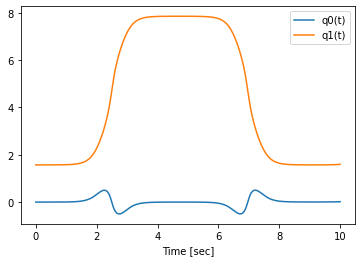

In [22]:
#Plot
from matplotlib.pyplot import plot
from matplotlib.pyplot import xlabel, legend
y_shape = int(y.shape[1]/2)
lines = plot(t, y[:, :y_shape])
lab = xlabel('Time [sec]')
leg = legend(dynamic[:y_shape])

In [23]:
#Simulation 
from numpy import zeros, cos, sin, arange, around
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle

In [24]:
def animate_pendulum(t, states, length, filename=None):
    """Animates the n-pendulum and optionally saves it to file.

    Parameters
    ----------
    t : ndarray, shape(m)
        Time array.
    states: ndarray, shape(m,p)
        State time history.
    length: float
        The length of the pendulum links.
    filename: string or None, optional
        If true a movie file will be saved of the animation. This may take some time.

    Returns
    -------
    fig : matplotlib.Figure
        The figure.
    anim : matplotlib.FuncAnimation
        The animation.

    """
    # the number of pendulum bobs
    numpoints = int(states.shape[1] / 2)

    # first set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()

    # some dimesions
    cart_width = 0.4
    cart_height = 0.2

    # set the limits based on the motion
    xmin = around(states[:, 0].min() - cart_width / 2.0, 1)
    xmax = around(states[:, 0].max() + cart_width / 2.0, 1)

    # create the axes
    ax = plt.axes(xlim=(xmin, xmax), ylim=(-1.1, 1.1), aspect='equal')

    # display the current time
    time_text = ax.text(0.04, 0.9, '', transform=ax.transAxes)

    # create a rectangular cart
    rect = Rectangle([states[0, 0] - cart_width / 2.0, -cart_height / 2],
        cart_width, cart_height, fill=True, color='red', ec='black')
    ax.add_patch(rect)

    # blank line for the pendulum
    line, = ax.plot([], [], lw=2, marker='o', markersize=6)

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        rect.set_xy((0.0, 0.0))
        line.set_data([], [])
        return time_text, rect, line,

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f}'.format(t[i]))
        rect.set_xy((states[i, 0] - cart_width / 2.0, -cart_height / 2))
        x = hstack((states[i, 0], zeros((numpoints - 1))))
        y = zeros((numpoints))
        for j in arange(1, numpoints):
            x[j] = x[j - 1] + length * cos(states[i, j])
            y[j] = y[j - 1] + length * sin(states[i, j])
        line.set_data(x, y)
        return time_text, rect, line,

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init, interval=t[-1] / len(t) * 1000, blit=True, repeat=False)
    
    # save the animation if a filename is given
    if filename is not None:
        anim.save(filename, fps=30, codec='libx264')



In [25]:
from matplotlib import animation
animation.writers.list()

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']

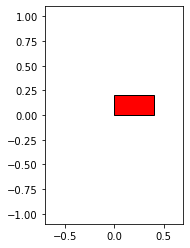

In [26]:
animate_pendulum(t, y, arm_length) #, filename="open-loop.mp4")

In [27]:
from IPython.display import HTML
h = \
"""
<video width="640" height="480" controls>
  <source src="files/open-loop.ogv" type="video/ogg">
  <source src="files/open-loop.mp4" type="video/mp4">
Your browser does not support the video tag, check out the YouTuve version instead: http://youtu.be/Nj3_npq7MZI.
</video>
"""
HTML(h)